# Skin Tone Classification — Model Training & Testing

This notebook trains a deep learning model for **Skin Tone Classification**, and then demonstrates how to **test the trained model**.

---

### Overview
- Build and train a model to classify different skin tones.  
- Save the trained model for future use.  
- Test the saved model on new images.  

Once the model is saved, it can later be uploaded as a **public model**, so that anyone can directly import and use it without retraining.

---

### Workflow Summary
1. **Data Preparation**
2. **Model Creation**
3. **Training**
4. **Saving the Model**
5. **Testing (just the first 4 & last 4 cells)**

> 💡 **If you only want to test the saved model:**  
> You don’t need to download or train anything — just **run the first 4 & last 4 cells**.


In [ ]:
#import libraries
import os
import random
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

In [ ]:
#download dataset
import kagglehub

path = kagglehub.dataset_download("adityakammati/skintone-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/adityakammati/skintone-dataset/versions/1


In [ ]:
# Check dataset folder structure, classes, and image counts for each split
DATASET_PATH = path

train_path = os.path.join(DATASET_PATH, "train")
val_path = os.path.join(DATASET_PATH, "valid")
test_path = os.path.join(DATASET_PATH, "test")

print("Train classes:", os.listdir(train_path))
print("Validation classes:", os.listdir(val_path))
print("Test classes:", os.listdir(test_path))

for split, path in [("Train", train_path), ("Validation", val_path), ("Test", test_path)]:
    total_images = sum(len(files) for _, _, files in os.walk(path))
    print(f"{split} images:", total_images)

Train classes: ['light', 'fair', 'dark']
Validation classes: ['light', 'fair', 'dark']
Test classes: ['light', 'fair', 'dark']
Train images: 1470
Validation images: 420
Test images: 210


In [ ]:
# Prepare image generators with preprocessing and augmentation
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess
)

# Load images from directories and create train, validation, and test generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_datagen.flow_from_directory(
    test_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Display number of classes and their labels
num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)
print("Class indices:", train_generator.class_indices)

Found 1470 images belonging to 3 classes.
Found 420 images belonging to 3 classes.
Found 210 images belonging to 3 classes.
Number of classes: 3
Class indices: {'dark': 0, 'fair': 1, 'light': 2}


# These cells are for training




In [ ]:
# Load base EfficientNetB0 model without the top layer (ImageNet weights)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze base model layers to use pretrained features
base_model.trainable = False

# Build classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


I0000 00:00:1762062149.550283      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762062149.550998      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
#train the model
EPOCHS = 10

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1762062246.051571     121 service.cc:148] XLA service 0x7a6a14113bb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762062246.052286     121 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762062246.052314     121 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762062247.921028     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/46 ━━━━━━━━━━━━━━━━━━━━ 20:20 27s/step - accuracy: 0.4333 - loss: 1.0722

I0000 00:00:1762062257.357521     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/46 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5026 - loss: 0.9847 - val_accuracy: 0.6452 - val_loss: 0.7503
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 437ms/step - accuracy: 0.6149 - loss: 0.7737 - val_accuracy: 0.6952 - val_loss: 0.6718
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 423ms/step - accuracy: 0.6639 - loss: 0.6900 - val_accuracy: 0.7524 - val_loss: 0.6181
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7269 - loss: 0.6216 - val_accuracy: 0.7500 - val_loss: 0.5883
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7295 - loss: 0.5871 - val_accuracy: 0.7643 - val_loss: 0.5596
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - accuracy: 0.7659 - loss: 0.5513 - val_accuracy: 0.7643 - val_loss: 0.5424
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.7499 - loss: 0.5644 - val_accuracy: 0.7881 - val_loss: 0.5224
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 19s 418ms/step - accuracy: 0.7720 - loss: 0.5294 - val_accuracy: 0.7762 -

In [ ]:
# Evaluate model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 999ms/step - accuracy: 0.8243 - loss: 0.4079
Test Accuracy: 74.29%
Test Loss: 0.5378


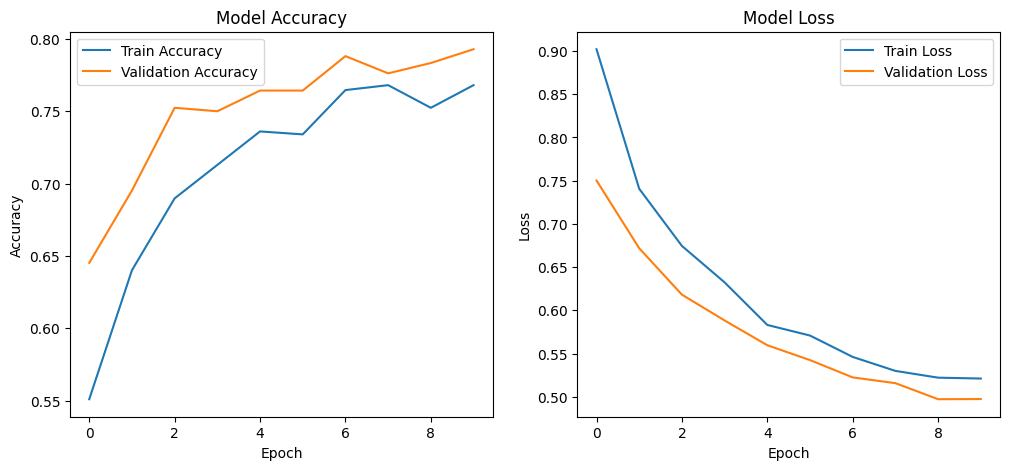

In [ ]:
# Plot training & validation accuracy and loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# Unfreeze top layers of EfficientNet for fine-tuning
base_model.trainable = True

# Fine-tune only top 20 layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Recompile with a very low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Continue training (fine-tuning)
fine_tune_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 69s 858ms/step - accuracy: 0.6899 - loss: 0.7110 - val_accuracy: 0.7857 - val_loss: 0.5087
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 425ms/step - accuracy: 0.6977 - loss: 0.6735 - val_accuracy: 0.7500 - val_loss: 0.5372
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 428ms/step - accuracy: 0.7340 - loss: 0.6376 - val_accuracy: 0.7524 - val_loss: 0.5513
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 430ms/step - accuracy: 0.7261 - loss: 0.6153 - val_accuracy: 0.7452 - val_loss: 0.5570
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7342 - loss: 0.5877 - val_accuracy: 0.7405 - val_loss: 0.5540
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 433ms/step - accuracy: 0.7193 - loss: 0.6091 - val_accuracy: 0.7452 - val_loss: 0.5487
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - accuracy: 0.7547 - loss: 0.5843 - val_accuracy: 0.7524 - val_loss: 0.5422
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 434ms/step - accuracy: 0.7556 - loss: 0.5603 - val_accu

In [ ]:
# Add stronger augmentation and continue fine-tuning
train_datagen = ImageDataGenerator(
    preprocessing_function=efficientnet_preprocess,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Recompile with smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune longer
fine_tune_history_2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Found 1470 images belonging to 3 classes.
Epoch 1/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 69s 879ms/step - accuracy: 0.7587 - loss: 0.5436 - val_accuracy: 0.7595 - val_loss: 0.5178
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 453ms/step - accuracy: 0.7402 - loss: 0.5597 - val_accuracy: 0.7619 - val_loss: 0.5144
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 456ms/step - accuracy: 0.7653 - loss: 0.5252 - val_accuracy: 0.7643 - val_loss: 0.5117
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 465ms/step - accuracy: 0.7622 - loss: 0.5569 - val_accuracy: 0.7690 - val_loss: 0.5091
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 448ms/step - accuracy: 0.7525 - loss: 0.5462 - val_accuracy: 0.7643 - val_loss: 0.5062
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.7911 - loss: 0.5172 - val_accuracy: 0.7643 - val_loss: 0.5029
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - accuracy: 0.7571 - loss: 0.5343 - val_accuracy: 0.7690 - val_loss: 0.4995
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 439ms/step - 

In [ ]:
# Unfreeze more of EfficientNet
base_model.trainable = True
for layer in base_model.layers[:-100]:
    layer.trainable = False

# Compile with Adam and slightly higher LR for warmup
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks: Reduce LR when plateau & stop early if no progress
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Fine-tune longer
fine_tune_history_3 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 70s 874ms/step - accuracy: 0.7851 - loss: 0.5053 - val_accuracy: 0.7690 - val_loss: 0.4840 - learning_rate: 1.0000e-05
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 431ms/step - accuracy: 0.7777 - loss: 0.4947 - val_accuracy: 0.7667 - val_loss: 0.4779 - learning_rate: 1.0000e-05
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - accuracy: 0.7735 - loss: 0.4831 - val_accuracy: 0.7738 - val_loss: 0.4729 - learning_rate: 1.0000e-05
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 437ms/step - accuracy: 0.8019 - loss: 0.4831 - val_accuracy: 0.7762 - val_loss: 0.4674 - learning_rate: 1.0000e-05
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 432ms/step - accuracy: 0.7857 - loss: 0.4820 - val_accuracy: 0.7833 - val_loss: 0.4613 - learning_rate: 1.0000e-05
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 452ms/step - accuracy: 0.7964 - loss: 0.4746 - val_accuracy: 0.7833 - val_loss: 0.4569 - learning_rate: 1.0000e-05
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 437ms/step - acc

In [ ]:
# Save the fine-tuned model (architecture + weights + optimizer state)
model.save("efficientnet_finetuned_v3.keras")

print("Model saved successfully as 'efficientnet_finetuned_v3.keras'")

Model saved successfully as 'efficientnet_finetuned_v3.keras'


In [ ]:
# Evaluate the final fine-tuned model on the test dataset
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 660ms/step - accuracy: 0.8687 - loss: 0.3117
Test Accuracy: 78.10%
Test Loss: 0.4722


In [ ]:
# --- Data Augmentation ---
augmented_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create augmented train generator
augmented_train_generator = augmented_train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# --- Validation remains same (no augmentation) ---
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1470 images belonging to 3 classes.
Found 420 images belonging to 3 classes.


In [ ]:
# --- Unfreeze more layers for deeper fine-tuning ---
base_model.trainable = True
for layer in base_model.layers[:-150]:
    layer.trainable = False

# --- Compile with smaller LR for stability ---
model.compile(
    optimizer=Adam(learning_rate=5e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# --- Fine-tune with Augmentation ---
fine_tune_history_aug = model.fit(
    augmented_train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 69s 875ms/step - accuracy: 0.3439 - loss: 1.2154 - val_accuracy: 0.3333 - val_loss: 1.0961 - learning_rate: 5.0000e-06
Epoch 2/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.3341 - loss: 1.1923 - val_accuracy: 0.3333 - val_loss: 1.1026 - learning_rate: 5.0000e-06
Epoch 3/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.3274 - loss: 1.1696 - val_accuracy: 0.3333 - val_loss: 1.1066 - learning_rate: 5.0000e-06
Epoch 4/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - accuracy: 0.3493 - loss: 1.1596
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-06.
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 441ms/step - accuracy: 0.3491 - loss: 1.1596 - val_accuracy: 0.3333 - val_loss: 1.1062 - learning_rate: 5.0000e-06
Epoch 5/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 435ms/step - accuracy: 0.3379 - loss: 1.1448 - val_accuracy: 0.3333 - val_loss: 1.1130 - learning_rate: 1.5000e-06
Epoch 6/25
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 444ms/step - accuracy

In [ ]:
# Load best model
model = load_model("/kaggle/working/efficientnet_finetuned_v3.keras")
model.summary()
print("Loaded stable model (val_acc ≈ 81.43%)")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 6,763,022 (25.80 MB)

 Trainable params: 1,354,803 (5.17 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

 Optimizer params: 2,709,608 (10.34 MB)

Loaded stable model (val_acc ≈ 81.43%)


In [ ]:
for i, layer in enumerate(model.layers[:10]):
    print(i, layer.name, type(layer))

0 input_layer <class 'keras.src.layers.core.input_layer.InputLayer'>
1 rescaling <class 'keras.src.layers.preprocessing.rescaling.Rescaling'>
2 normalization <class 'keras.src.layers.preprocessing.normalization.Normalization'>
3 rescaling_1 <class 'keras.src.layers.preprocessing.rescaling.Rescaling'>
4 stem_conv_pad <class 'keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D'>
5 stem_conv <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
6 stem_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
7 stem_activation <class 'keras.src.layers.activations.activation.Activation'>
8 block1a_dwconv <class 'keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>
9 block1a_bn <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
10 block1a_activation <class 'keras.src.layers.activations.activation.Activation'>
11 block1a_se_squeeze <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
12 block

In [ ]:
# Unfreeze the top 100 layers of the entire model
for layer in model.layers[:-100]:
    layer.trainable = False
for layer in model.layers[-100:]:
    layer.trainable = True

# Recompile the model with a low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Verify
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,053,414 (15.46 MB)

 Trainable params: 3,481,975 (13.28 MB)

 Non-trainable params: 571,439 (2.18 MB)

In [ ]:
# Reload the stable model (81.43%)
model = load_model("/kaggle/working/efficientnet_finetuned_v3.keras")

# Check total layers in flattened structure
total_layers = len(model.layers)
print(f"Total layers: {total_layers}")

# Unfreeze the *top 60 layers* for deep fine-tuning (tweakable)
for layer in model.layers[:-60]:
    layer.trainable = False
for layer in model.layers[-60:]:
    layer.trainable = True

# Recompile with very small LR
model.compile(
    optimizer=Adam(learning_rate=3e-6),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Fine-tune using SAME generators (no label remap)
fine_tune_history_flat = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

Total layers: 241
Epoch 1/20


E0000 00:00:1762065255.624373     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762065255.775032     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762065255.915918     121 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


40/46 ━━━━━━━━━━━━━━━━━━━━ 2s 421ms/step - accuracy: 0.7785 - loss: 0.4928

E0000 00:00:1762065285.324634     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1762065285.470483     119 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


46/46 ━━━━━━━━━━━━━━━━━━━━ 82s 946ms/step - accuracy: 0.7770 - loss: 0.4942 - val_accuracy: 0.8024 - val_loss: 0.4213 - learning_rate: 3.0000e-06
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 443ms/step - accuracy: 0.7744 - loss: 0.4803 - val_accuracy: 0.7857 - val_loss: 0.4316 - learning_rate: 3.0000e-06
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - accuracy: 0.7977 - loss: 0.4789 - val_accuracy: 0.7952 - val_loss: 0.4311 - learning_rate: 3.0000e-06
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step - accuracy: 0.7774 - loss: 0.4976
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.000000318337698e-07.
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.7776 - loss: 0.4973 - val_accuracy: 0.8119 - val_loss: 0.4278 - learning_rate: 3.0000e-06
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 20s 440ms/step - accuracy: 0.7751 - loss: 0.4612 - val_accuracy: 0.8071 - val_loss: 0.4303 - learning_rate: 9.0000e-07
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 445ms/step - accuracy: 0.8021 - l

In [ ]:
# --- Unfreeze last 170 layers for deeper fine-tuning ---
total_layers = len(model.layers)
print(f"Total layers in model: {total_layers}")

# Unfreeze last 170 layers safely
for layer in model.layers[:-120]:
    layer.trainable = False
for layer in model.layers[-120:]:
    layer.trainable = True

# Confirm trainable vs non-trainable count
trainable_count = np.sum([layer.trainable for layer in model.layers])
print(f"Trainable layers: {trainable_count} / {total_layers}")

# --- Compile with very small learning rate ---
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks: Reduce LR when plateau & stop early if no progress
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
]

# Fine-tune longer
fine_tune_history_3 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)


Total layers in model: 241
Trainable layers: 120 / 241
Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.7002 - loss: 0.5829 - val_accuracy: 0.7976 - val_loss: 0.4379 - learning_rate: 1.0000e-05
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.7796 - loss: 0.5057 - val_accuracy: 0.8143 - val_loss: 0.4233 - learning_rate: 1.0000e-05
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 446ms/step - accuracy: 0.7507 - loss: 0.5107 - val_accuracy: 0.8214 - val_loss: 0.4181 - learning_rate: 1.0000e-05
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.7781 - loss: 0.4945 - val_accuracy: 0.8190 - val_loss: 0.4146 - learning_rate: 1.0000e-05
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 21s 458ms/step - accuracy: 0.7763 - loss: 0.4660 - val_accuracy: 0.8214 - val_loss: 0.4079 - learning_rate: 1.0000e-05
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 22s 471ms/step - accuracy: 0.7886 - loss: 0.4788 - val_accuracy: 0.8286 - val_loss: 0.4030 - learning_rate: 1.0000e-05
Epoch

In [ ]:
# Save final fine-tuned model safely
model.save("efficientnet_finetuned_v5.keras")
print("✅ Model saved successfully as 'efficientnet_finetuned_v5.keras'")

✅ Model saved successfully as 'efficientnet_finetuned_v5.keras'


In [ ]:
model = load_model("efficientnet_finetuned_v5.keras")

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.8694 - loss: 0.2652
Test Accuracy: 0.7905


7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step
📊 Classification Report:

              precision    recall  f1-score   support

        dark       0.91      1.00      0.95        70
        fair       0.77      0.67      0.72        70
       light       0.68      0.70      0.69        70

    accuracy                           0.79       210
   macro avg       0.79      0.79      0.79       210
weighted avg       0.79      0.79      0.79       210



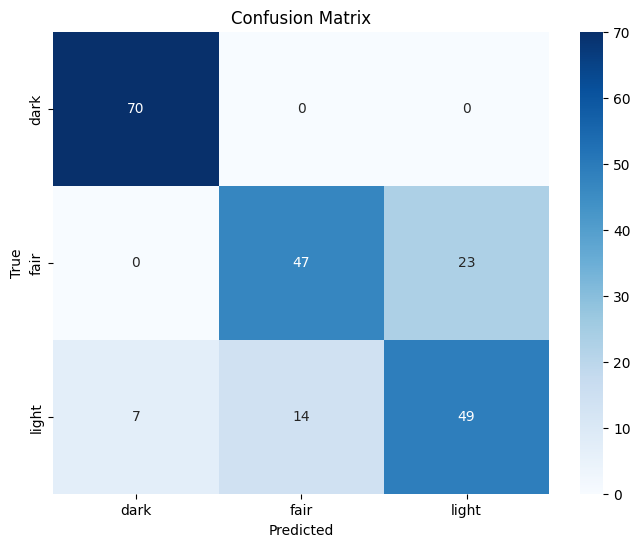

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure generator does not shuffle
test_generator.reset()

# Predict on test set
preds = model.predict(test_generator)
y_pred = np.argmax(preds, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [32]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

def predict_image(img_path, model, target_size=(224, 224), class_labels=None):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    predicted_idx = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))

    if class_labels:
        class_list = list(class_labels)
        predicted_class = class_list[predicted_idx]
    else:
        predicted_class = str(predicted_idx)

    print(f"✅ Predicted: {predicted_class}  (Confidence: {confidence:.2f})")
    return predicted_class, confidence


# ✅ Pass class labels as a proper list
class_labels = list(train_generator.class_indices.keys())

# Example usage
img_path = "/kaggle/input/testjpeg"
predict_image(img_path, model, target_size=(224, 224), class_labels=class_labels)


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/testjpeg'

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


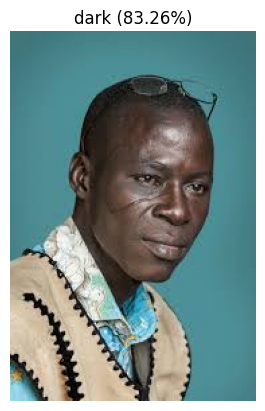

✅ Predicted: dark  (Confidence: 0.83)


('dark', 0.8326009511947632)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

def predict_and_show(img_path, model, target_size=(224, 224), class_labels=None):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_array_exp = preprocess_input(img_array_exp)

    preds = model.predict(img_array_exp)
    predicted_idx = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))

    if class_labels:
        class_list = list(class_labels)
        predicted_class = class_list[predicted_idx]
    else:
        predicted_class = str(predicted_idx)

    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence*100:.2f}%)")
    plt.show()

    print(f"✅ Predicted: {predicted_class}  (Confidence: {confidence:.2f})")
    return predicted_class, confidence


# Example usage
class_labels = list(train_generator.class_indices.keys())
img_path = "/kaggle/input/images-test-8/aa.jpeg"
predict_and_show(img_path, model, target_size=(224, 224), class_labels=class_labels)


# Model Testing — Run from Here

In [ ]:
model_path = kagglehub.model_download("adityakammati/skintone-images-model/keras/default")
model_file = os.path.join(model_path, "efficientnet_finetuned_v5.keras")

print("Path to model files:", model_path)

Path to model files: /root/.cache/kagglehub/models/adityakammati/skintone-images-model/keras/default/1


In [23]:
model = load_model(model_file)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}")



7/7 ━━━━━━━━━━━━━━━━━━━━ 15s 717ms/step - accuracy: 0.8694 - loss: 0.2652
Test Accuracy: 0.7905


In [30]:
test_path = os.path.join(DATASET_PATH, "test")

first_class = sorted(os.listdir(test_path))[0]

first_image = sorted(os.listdir(os.path.join(test_path, first_class)))[0]

test_image_path = os.path.join(test_path, first_class, first_image)

print("First test image path:", test_image_path)

First test image path: /root/.cache/kagglehub/datasets/adityakammati/skintone-dataset/versions/1/test/dark/104880284_jpg.rf.a9e9b792e5c4f3df8187b8ddd122d9ea.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


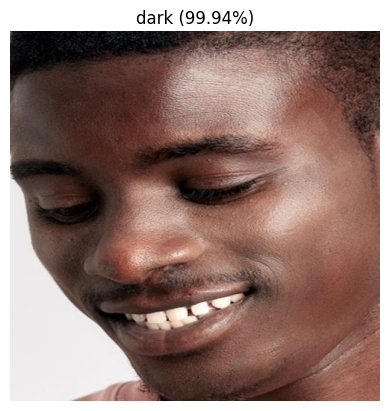

✅ Predicted: dark  (Confidence: 1.00)


('dark', 0.9994007349014282)

In [31]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np

def predict_and_show(img_path, model, target_size=(224, 224), class_labels=None):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array_exp = np.expand_dims(img_array, axis=0)
    img_array_exp = preprocess_input(img_array_exp)

    preds = model.predict(img_array_exp)
    predicted_idx = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))

    if class_labels:
        class_list = list(class_labels)
        predicted_class = class_list[predicted_idx]
    else:
        predicted_class = str(predicted_idx)

    plt.imshow(image.load_img(img_path))
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence*100:.2f}%)")
    plt.show()

    print(f"✅ Predicted: {predicted_class}  (Confidence: {confidence:.2f})")
    return predicted_class, confidence


# Example usage
class_labels = list(train_generator.class_indices.keys())
predict_and_show(test_image_path, model, target_size=(224, 224), class_labels=class_labels)